In [1]:
import pandas as pd
import ase
from ase import io
import numpy as np
import pandas as pd
import dionysus
import diode
from scipy.signal import argrelextrema

In [90]:
from ase import Atoms

class glass_Atoms(Atoms):
    #def __init__(self):
    #    super().__init__()

    def get_dist(self):
        dim = np.diagonal(self.get_cell())
        positions = self.get_positions()
        x_dif = np.abs(positions[:, 0][np.newaxis, :] - positions[:, 0][:, np.newaxis])
        y_dif = np.abs(positions[:, 1][np.newaxis, :] - positions[:, 1][:, np.newaxis])
        z_dif = np.abs(positions[:, 2][np.newaxis, :] - positions[:, 2][:, np.newaxis])
        x_dif = np.where(x_dif > 0.5 * dim[0], np.abs(x_dif - dim[0]), x_dif)
        y_dif = np.where(y_dif > 0.5 * dim[1], np.abs(y_dif - dim[1]), y_dif)
        z_dif = np.where(z_dif > 0.5 * dim[2], np.abs(z_dif - dim[2]), z_dif)
        i_i = np.sqrt(x_dif ** 2 + y_dif ** 2 + z_dif ** 2)
        return i_i
    
    def get_pdf(self, target_atoms, rrange=10, nbin=100):
        if isinstance(target_atoms[0], str):
            types = self.get_chemical_symbols()
        if isinstance(target_atoms[0], int):
            types = self.get_atomic_numbers()
        types = np.array(types)
        distances = self.get_dist()
        atom_1 = np.where(types==target_atoms[0])[0]
        atom_2 = np.where(types==target_atoms[1])[0]
        dist_list = distances[np.ix_(atom_1,atom_2)]
        edges = np.linspace(0, rrange, nbin+1)
        xval = edges[1:]-0.5*(rrange/nbin)
        volbin = []
        for i in range(nbin):
            vol = ((4/3)*np.pi*(edges[i+1])**3)-((4/3)*np.pi*(edges[i])**3)
            volbin.append(vol)

        h, bin_edges = np.histogram(dist_list, bins=nbin, range=(0, rrange))
        h[0] = 0
        pdf = (h/volbin)/(dist_list.shape[0]*dist_list.shape[1]/self.get_volume())
        return xval, pdf
    
    def get_persistence_diagram(self, dimension=1, weights=None):
        coord = self.get_positions()
        cell = self.get_cell()
        data = np.column_stack([self.get_chemical_symbols(),coord])
        dfpoints = pd.DataFrame(data, columns=["Atom", "x", "y", "z"])
        chem_species = np.unique(self.get_chemical_symbols())
        
        if weights == None:
            radii = [0 for i in chem_species]
        elif isinstance(weights, dict):
            radii = [weights[i] for i in chem_species]
        elif isinstance(weights, list):
            radii = weights

        conditions = [(dfpoints["Atom"]==i) for i in chem_species]
        choice_weight=[i**2 for i in radii]

        dfpoints["w"] = np.select(conditions,choice_weight)
        dfpoints["x"] = pd.to_numeric(dfpoints["x"])
        dfpoints["y"] = pd.to_numeric(dfpoints["y"])
        dfpoints["z"] = pd.to_numeric(dfpoints["z"])

        points=dfpoints[["x","y","z","w"]].to_numpy()
        simplices = diode.fill_weighted_alpha_shapes(points)
        f = dionysus.Filtration(simplices)
        m = dionysus.homology_persistence(f, progress=True)
        dgms = dionysus.init_diagrams(m, f)

        # Gather the PD of loop in a dataframe
        dfPD = pd.DataFrame(data={"Birth" : [p.birth for p in dgms[dimension]],
                                  "Death" : [p.death for p in dgms[dimension]],})
        return dfPD
    
    def get_local_persistence(self, center_id):
        persistence_diagrams = []
        centers = np.where(self.get_atomic_numbers()==center_id)[0]
        for i in centers:
            neighbors = np.where(self.get_dist()[i,:] < 5)[0]
            neighborhood = self[neighbors]
            neighborhood.center()
            persistence_diagrams.append(neighborhood.get_persistence_diagram())
        return persistence_diagrams
    
    def get_angular_dist(self, center_type, neigh_type, cutoff='Auto'):
        distances = self.get_dist()

        types = self.get_atomic_numbers()
        center_index = np.where(types==center_type)[0]
        neigh_index = np.where(types==neigh_type)[0]

        if cutoff == 'Auto':
            pdf = self.get_pdf(target_atoms=[center_type,neigh_type])
            cutoff = pdf[0][self.find_min_after_peak(pdf[1])]
        elif isinstance(cutoff, float | int):
            cutoff = cutoff

        angles = []

        for center in center_index:
            neighbors = np.where((distances[neigh_index,center]<cutoff) & (distances[neigh_index,center]>0))[0]
            if neighbors.shape[0] < 2:
                continue
            upper_index = np.triu_indices(neighbors.shape[0], k=1)
            comb_1 = np.meshgrid(neighbors,neighbors)[0][upper_index]
            comb_2 = np.meshgrid(neighbors,neighbors)[1][upper_index]
            indicies = np.vstack((neigh_index[comb_1], np.full(len(comb_1),center), neigh_index[comb_2])).T
            angles.append(self.get_angles(indicies, mic=True))
        return angles
    

    def get_coordination_number(self, center_type, neigh_type, cutoff='Auto'):
        distances = self.get_dist()
        types = self.get_atomic_numbers()
        atom_1 = np.where(types==center_type)[0]
        atom_2 = np.where(types==neigh_type)[0]
        dist_list = distances[np.ix_(atom_1,atom_2)]

        if cutoff == 'Auto':
            pdf = self.get_pdf(target_atoms=[center_type,neigh_type])
            cutoff = pdf[0][self.find_min_after_peak(pdf[1])]
        elif isinstance(cutoff, float | int):
            cutoff = cutoff
        print(cutoff)
        coordination_numbers = []
        for center in range(len(atom_1)):
            neighbors = np.where((dist_list[center,:]<cutoff) & (dist_list[center,:]>0))[0]
            coordination_numbers.append(neighbors.shape[0])
        return coordination_numbers
    
    def find_min_after_peak(self, padf):
        mins = argrelextrema(padf, np.less_equal, order=4)[0]
        second_min = [i for ind, i in enumerate(mins) if i != ind][0]
        return second_min


    def NBO_analysis(distances, center_index, neigh_index_1, neigh_index_2 ,cutoffs):
        P_neigh_unique = []
        for center in center_index:
            neighbors = np.where((distances[neigh_index,center]<cutoff[0]) & (distances[neigh_index,center]>0))[0]
            P_neigh_unique.append([O_ind[neigh] for neigh in neighbors])
        P_neigh_unique = np.unique(np.hstack(P_neigh_unique))

        bond_order = [0,0,0,0]
        for neigh in P_neigh_unique:
            neighbor_list_1 = np.where((distances[neigh_index_1,neigh]<cutoff[0]) & (distances[neigh_index_1,neigh]>0))[0]
            neighbor_list_2 = np.where((distances[neigh_index_2,neigh]<cutoff[1]) & (distances[neigh_index_2,neigh]>0))[0]

            if neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 1:
                bond_order[0] += 1
            elif neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 2:
                bond_order[1] += 1
            elif neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 3:
                bond_order[2] += 1
            elif neighbor_list_P.shape[0] + neighbor_list_Fe.shape[0] == 0:
                bond_order[3] +=1
        return coordination_number
    
    def get_total_rdf(self, nbin=100, rrange=10):
        scattering_lengths = pd.read_csv('scattering_lengths.csv', sep=';', decimal=',')
        chemical_symbols = self.get_chemical_symbols()
        species = np.unique(chemical_symbols)
        b = np.array([scattering_lengths[scattering_lengths["Isotope"] == i]["b"] for i in species]).flatten()
        c = [chemical_symbols.count(i) / len(chemical_symbols) for i in species]
        cb = [i*j for i, j in zip(c, b)]
        timesby = []
        for pair in itertools.product(cb, repeat=2):
            timesby.append(pair[0]*pair[1])
        dividetot = sum(timesby)
        cb_sum = (sum([i*j for i, j in zip(c, b)])**2)/100

        gr_tot = np.zeros([nbin])
        for ind, pair in enumerate(itertools.product(species, repeat=2)):
            pdf = self.get_pdf(target_atoms=[pair[0],pair[1]], rrange=rrange, nbin=nbin)
            gr_tot = gr_tot + (timesby[ind]*pdf[1])/dividetot
        return pdf[0], gr_tot




In [91]:
atom = io.read(f"/Users/rasmus/Library/CloudStorage/OneDrive-AalborgUniversitet/Ph.D. Projekt/sodium_silicate/30Na_800/data/114/propensity/27/md.lammpstrj", index=0 , format="lammps-dump-text")
atom = glass_Atoms(atom)

atomic_numbers = atom.get_atomic_numbers()
corr_atoms_dic = {1: 'Na', 2: 'O', 3:'Si'}
corr_symbols= [corr_atoms_dic[i] for i in atomic_numbers]
atomic_numbers = atom.set_chemical_symbols(corr_symbols)


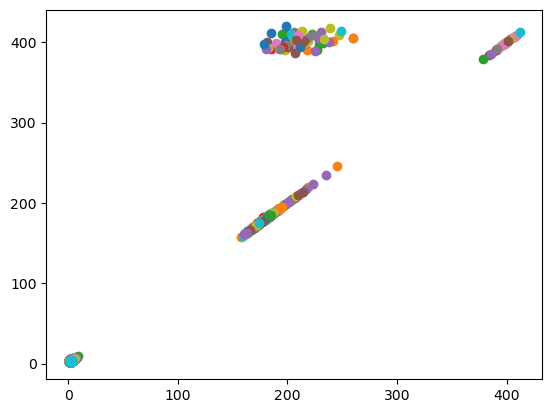

In [124]:
import matplotlib.pyplot as plt

for i in (peristence_diag):
    plt.scatter(i['Birth'], i['Death'])

In [139]:
atom = glass_Atoms(atom)
distances = atom.get_dist()
types = atom.get_atomic_numbers()
atom_1 = np.where(types==2)[0]
atom_2 = np.where(types==3)[0]
dist_list = distances[np.ix_(atom_1,atom_2)]

coordination_numbers = []
for center in range(len(atom_1)):
    neighbors = np.where((dist_list[center,:]<2) & (dist_list[center,:]>0))[0]
    coordination_numbers.append(neighbors.shape[0])


In [88]:
import pandas as pd


scattering_lengths = pd.read_csv('scattering_lengths.csv', sep=';', decimal=',')
chemical_symbols = atom.get_chemical_symbols()
species = np.unique(chemical_symbols)
b = np.array([scattering_lengths[scattering_lengths["Isotope"] == i]["b"] for i in species]).flatten()
c = [chemical_symbols.count(i) / len(chemical_symbols) for i in species]

cb = [i*j for i, j in zip(c, b)]
timesby = []
for pair in itertools.product(cb, repeat=2):
    timesby.append(pair[0]*pair[1])
dividetot = sum(timesby)
cb_sum = (sum([i*j for i, j in zip(c, b)])**2)/100

gr_tot = np.zeros([100])
for ind, pair in enumerate(itertools.product(species, repeat=2)):
    gr_tot = gr_tot + (timesby[ind]*atom.get_pdf(target_atoms=[pair[0],pair[1]], rrange=10, nbin=100)[1])/dividetot

#gr_tot_broad = broad(gr_tot, xval, 50)



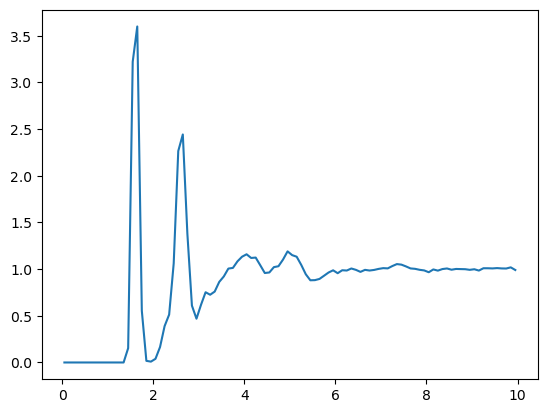

In [95]:
import matplotlib.pyplot as plt
xval, total_rdf = atom.get_total_rdf()
plt.plot(xval, total_rdf)